# Paragone tra le metriche dei giornali di matematica

In questo script si cerca di fare un paragone delle diverse metriche delle riviste di matematica.

In [5]:
import pandas # Per l'elaborazione dei file csv
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind # Per i test statistici

## Elenco delle riviste ammissibili

Per poter effettuare la valutazione, ci restringiamo all'elenco delle riviste ammissibili secondo ANVUR. Questa lista è ottenuta dagli ultimi dati ANVUR disponibili e relativi alla VQR 2015-2019 al sito: https://www.anvur.it/attivita/vqr/vqr-2015-2019/gev/area-1-scienze-matematiche-e-informatiche/ 

In [6]:
matjournal = {}
for i in [1,2,3,5,6,7,8,9]:
    matjournal[i] = pandas.read_csv('ListaMCQ-SCOPUS/MAT0'+str(i)+'SCOPUS.csv',sep=";")

## Leggiamo i diversi ranking

Per prima cosa carichiamo in memoria i diversi _ranking_ delle riviste. Utilizzeremo per questa analisi
1. Scimago Journal Rank
2. Scopus CiteScore
3. Math Citation Quotient (come riportato dalle tabelle ANVUR/Scopus caricate al punto precedente)
4. SNIP: Source-normalized Impact per Paper, calcolato dal Leiden University Centre for Science and Technology Studies (CWTS) basato sui dati bibliografici di Scopus (Elsevier).

In [7]:
scimago = pandas.read_csv('scimagojr2019.csv',sep=";",low_memory=False) # Dataset SCIMAGO
scopus = pandas.read_csv('scopusextlistMarch2023.csv',sep=";") # Dataset SCOPUS
cwts = pandas.read_excel('CWTS Journal Indicators April 2023.xlsx') # Dataset CWTS

# Costruzione tabella di paragone

Per guardare al comportamento delle diverse misure costruiamo una tabella che contiene:

|Nome della rivista|ISSN|Settore di Appartenenza|SJR|CiteScore|MCQ|SNIP|

Questa tabella avrà righe ripetute perché alcune riviste figureranno per più settori disciplinari. 

In [8]:
df = pandas.DataFrame(columns=['Rivista', 'ISSN', 'SETTORE','SJR','CiteScore','MCQ'])
index = 0
for i in [1,2,3,5,6,7,8,9]:
    for j in range(len(matjournal[i])):
        row = matjournal[i].iloc[[j]]
        titolo = row['Source Title'].iloc[0]
        issn = row['p_issn'].iloc[0]
        settore = 'MAT0'+str(i)
        # Scimago Journal Rank
        if len(scimago.loc[scimago['Title'] == titolo,'SJR']) == 0:
            e_issn = row['e_issn'].iloc[0]
            p_issn = row['p_issn'].iloc[0] 
            if pandas.isna(e_issn):
                chekissn = p_issn;
            else:
                chekissn = e_issn+', '+p_issn
            if len(scimago.loc[scimago['Issn'] == chekissn,'SJR']) == 0:
                sjr = 0
            else:
                if pandas.isna(scimago.loc[scimago['Issn'] == chekissn,'SJR'].values[0]):
                    sjr = 0
                else:
                    sjr = float(scimago.loc[scimago['Issn'] == chekissn,'SJR'].values[0].replace(',', '.'))
        else:
            if pandas.isna(scimago.loc[scimago['Title'] == titolo,'SJR'].values[0]):
                sjr = 0
            else:
                sjr = float(scimago.loc[scimago['Title'] == titolo,'SJR'].values[0].replace(',', '.'))
        if i < 9:
            mcq = float(row['MCQ'].iloc[0].replace(',', '.'))
        else:
            mcq = 0
        # Scopus CiteScore
        if len(scopus.loc[scopus['Source Title (Medline-sourced journals are indicated in Green)'] == titolo,'2021\nCiteScore']) == 0:
            citescore = float(scopus.loc[scopus['Print-ISSN'] == issn,'2021\nCiteScore'].values[0])
        else:
            citescore = float(scopus.loc[scopus['Source Title (Medline-sourced journals are indicated in Green)'] == titolo,'2021\nCiteScore'].values[0])
        # SNIP-CWTS
        if len(cwts.loc[cwts['Source title'] == titolo,'SNIP']) == 0:
            p_issn = row['p_issn'].iloc[0] 
            e_issn = row['e_issn'].iloc[0]
            if len(cwts.loc[cwts['Print ISSN'] == p_issn,'SNIP']) == 0:
                if len(cwts.loc[cwts['Electronic ISSN'] == e_issn,'SNIP']) == 0:
                    snip = 0
                    #DEBUG: print('I cannot find journal (SNIP): '+titolo)
                else:
                    snip = float(cwts.loc[cwts['Electronic ISSN'] == e_issn,'SNIP'].values[-1])                        
            else:
                snip = float(cwts.loc[cwts['Print ISSN'] == p_issn,'SNIP'].values[-1])
        else:
            snip = float(cwts.loc[cwts['Source title'] == titolo,'SNIP'].values[-1])
        # Decomment for debug:
        # print(titolo+' '+issn+' '+' '+str(sjr)+' '+' 0 '+str(mcq) + ' SNIP ' + str(snip))
        newline = pandas.DataFrame({"Rivista": titolo, 
                                   "ISSN": issn,
                                   "SETTORE": settore,
                                   "SJR": sjr,
                                   "CiteScore": citescore,
                                   "MCQ": mcq,
                                   "SNIP": snip},index=[index]);
        df = pandas.concat([df,newline])
        index = index + 1

# Correlazione indici per settore disciplinare
Indaghiamo la correlazione dei diversi indici delle riviste per settore scientifico disciplinare. Per prima cosa visualizziamo degli _scatterplot_ delle varie misure. Idealmente **indici corellati** avranno valori che si addensano sulla diagonale principale della figura. Controlliamo gli indici a due a due.

### MCQ vs SJR

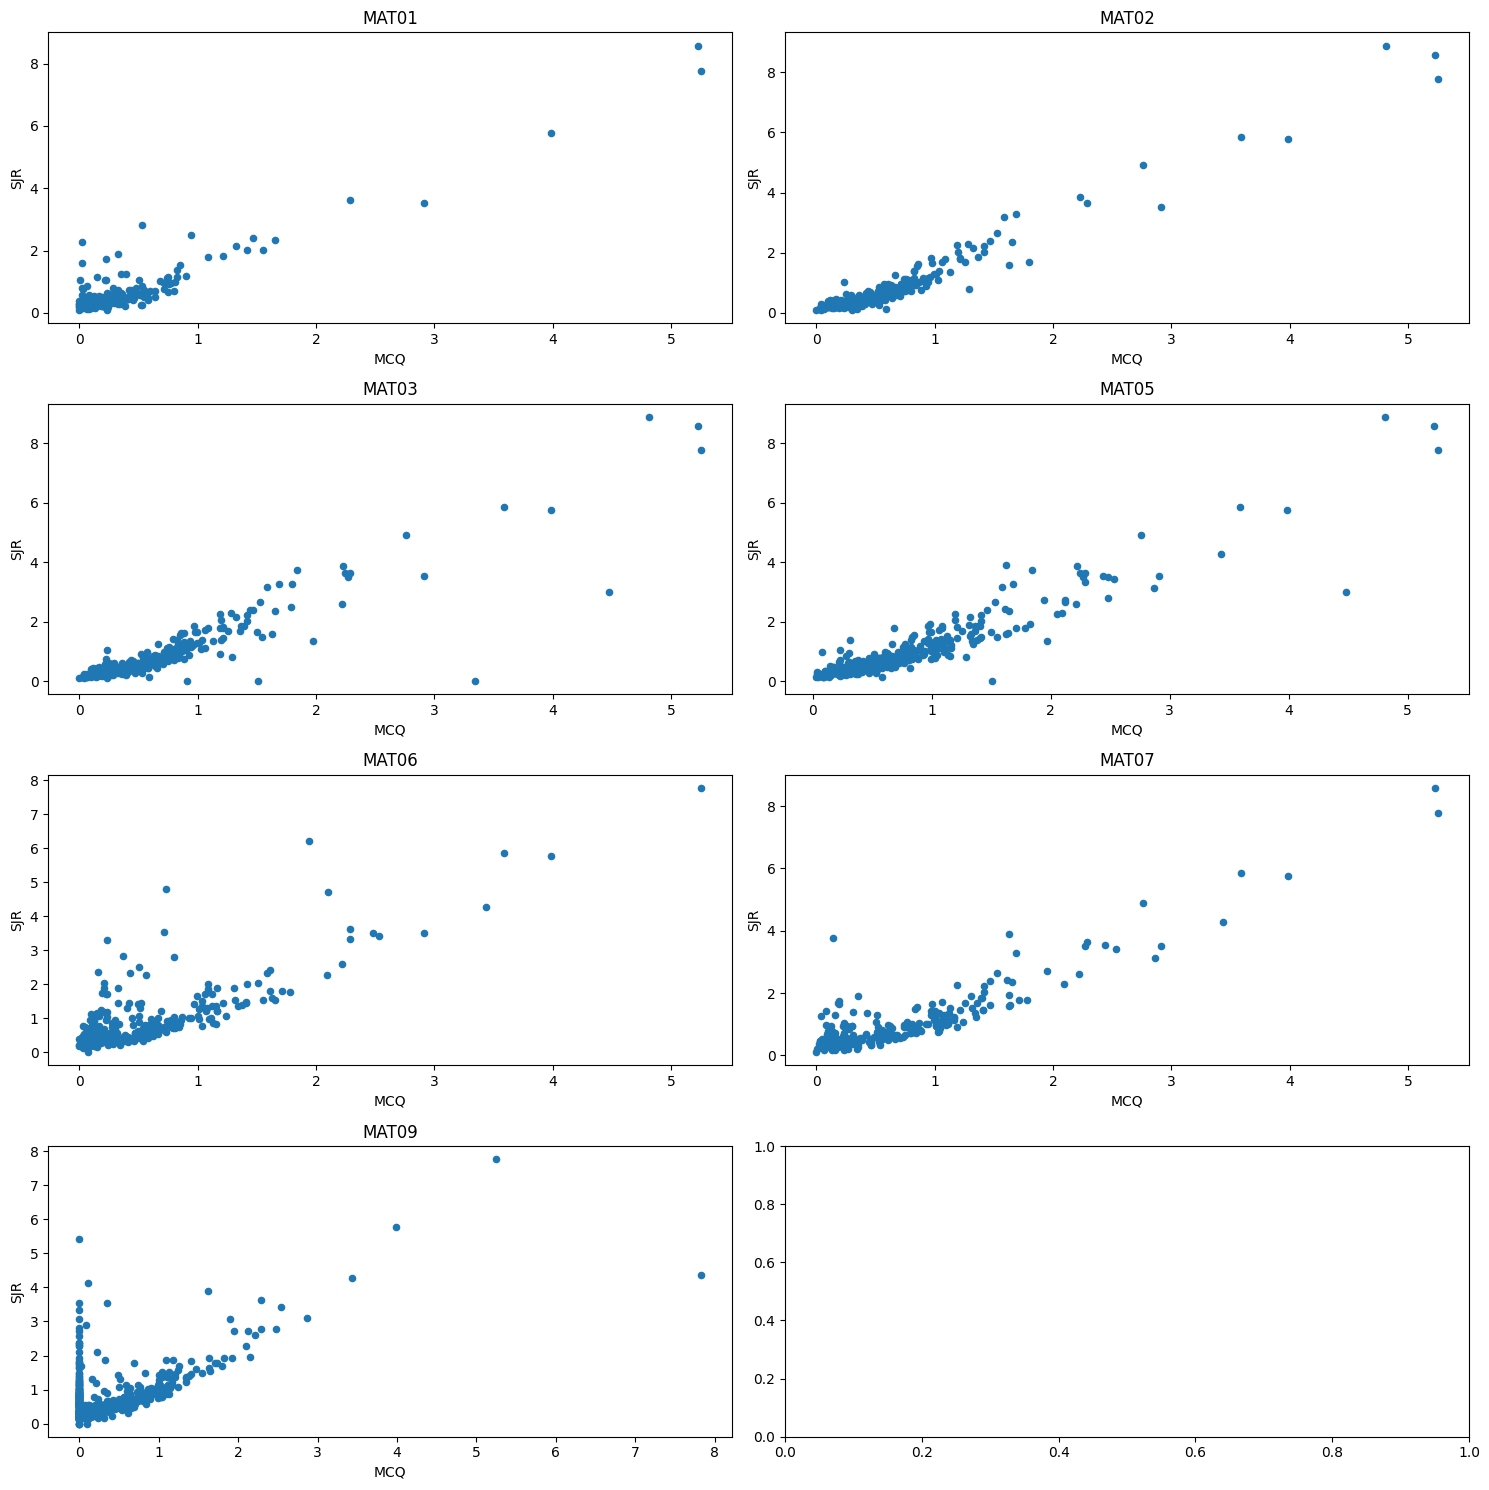

In [9]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="MCQ",y="SJR",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="MCQ",y="SJR",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="MCQ",y="SJR",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="MCQ",y="SJR",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="MCQ",y="SJR",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="MCQ",y="SJR",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="MCQ",y="SJR",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="MCQ",y="SJR",ax=axes[3,0],title="MAT09")
plt.tight_layout()


Visivamente si osserva che i due _score_ potrebbero avere un qualche livello di correlazione reciproca. Possiamo indagare ulteriormente la questione guardando ai t-score (normalizzati per avere tutte le misure in $[0,1]$):

In [10]:
for i in [1,2,3,5,6,7,8,9]:
    settore = 'MAT0'+str(i)
    mcq = df.loc[df['SETTORE']==settore,'MCQ']
    sjr = df.loc[df['SETTORE']==settore,'SJR']
    mcq = mcq/max(mcq)
    sjr = sjr/max(sjr)
    results = ttest_ind(mcq, sjr)
    if results.pvalue < 0.05:
        print("Per il settore "+settore+" non c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")
    else:
        print("Per il settore "+settore+" c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")     

Per il settore MAT01 c'è correlazione (p = 0.7855614384657014, stat = -0.2722763219018609)
Per il settore MAT02 non c'è correlazione (p = 0.03357012604091434, stat = 2.13072071771312)
Per il settore MAT03 non c'è correlazione (p = 0.003922235037200082, stat = 2.895261310147692)
Per il settore MAT05 non c'è correlazione (p = 5.603028299089055e-05, stat = 4.051647323873512)
Per il settore MAT06 c'è correlazione (p = 0.11104136070391513, stat = -1.5961071345180546)
Per il settore MAT07 c'è correlazione (p = 0.25538216419412824, stat = 1.1387628670675873)
Per il settore MAT08 non c'è correlazione (p = 0.003960470790739886, stat = -2.8954333676774295)
Per il settore MAT09 c'è correlazione (p = nan, stat = nan)


Tuttavia anche la debole correlazione che osserviamo, salta se assumiamo che distribuzioni non abbiano uguale varianza

In [11]:
for i in [1,2,3,5,6,7,8,9]:
    settore = 'MAT0'+str(i)
    mcq = df.loc[df['SETTORE']==settore,'MCQ']
    sjr = df.loc[df['SETTORE']==settore,'SJR']
    mcq = mcq/max(mcq)
    sjr = sjr/max(sjr)
    ttest_ind(mcq, sjr,equal_var=False)
    if results.pvalue < 0.05:
        print("Per il settore "+settore+" non c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")
    else:
        print("Per il settore "+settore+" c'è correlazione (p = "+str(results.pvalue)+", stat = "+str(results.statistic)+")")  

Per il settore MAT01 c'è correlazione (p = nan, stat = nan)
Per il settore MAT02 c'è correlazione (p = nan, stat = nan)
Per il settore MAT03 c'è correlazione (p = nan, stat = nan)
Per il settore MAT05 c'è correlazione (p = nan, stat = nan)
Per il settore MAT06 c'è correlazione (p = nan, stat = nan)
Per il settore MAT07 c'è correlazione (p = nan, stat = nan)
Per il settore MAT08 c'è correlazione (p = nan, stat = nan)
Per il settore MAT09 c'è correlazione (p = nan, stat = nan)


Proviamo ad ispezionare le prime riviste per i diversi indici

In [12]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['MCQ'],ascending=False).head(10)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,9.857442
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,5.889578
1665,Acta Mathematica,00015962,MAT08,5.766,7.2,3.984615,4.116369
1703,Communications on Pure and Applied Mathematics,00103640,MAT08,4.271,5.8,3.434615,2.632944
1838,Mathematical Models and Methods in Applied Sci...,02182025,MAT08,3.114,6.0,2.865526,1.519753
1685,Archive for Rational Mechanics and Analysis,00039527,MAT08,3.420,4.4,2.534338,1.860431
1885,SIAM Journal on Numerical Analysis,00361429,MAT08,2.780,5.3,2.481375,1.779797
1722,Computer Methods in Applied Mechanics and Engi...,00457825; 03742830,MAT08,2.786,10.3,2.292758,2.150712
1825,Journal of the European Mathematical Society,14359855,MAT08,3.639,3.7,2.287129,2.553470
1781,Journal des Mathematiques Pures et Appliquees,00217824,MAT08,2.601,4.0,2.217391,2.095639


In [13]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['SJR'],ascending=False).head(40)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,5.889578
1665,Acta Mathematica,00015962,MAT08,5.766,7.2,3.984615,4.116369
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,9.857442
1703,Communications on Pure and Applied Mathematics,00103640,MAT08,4.271,5.8,3.434615,2.632944
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,5.069936
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,4.887166
1825,Journal of the European Mathematical Society,14359855,MAT08,3.639,3.7,2.287129,2.553470
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,3.984138
1685,Archive for Rational Mechanics and Analysis,00039527,MAT08,3.420,4.4,2.534338,1.860431
1838,Mathematical Models and Methods in Applied Sci...,02182025,MAT08,3.114,6.0,2.865526,1.519753


### MCQ vs CiteScore

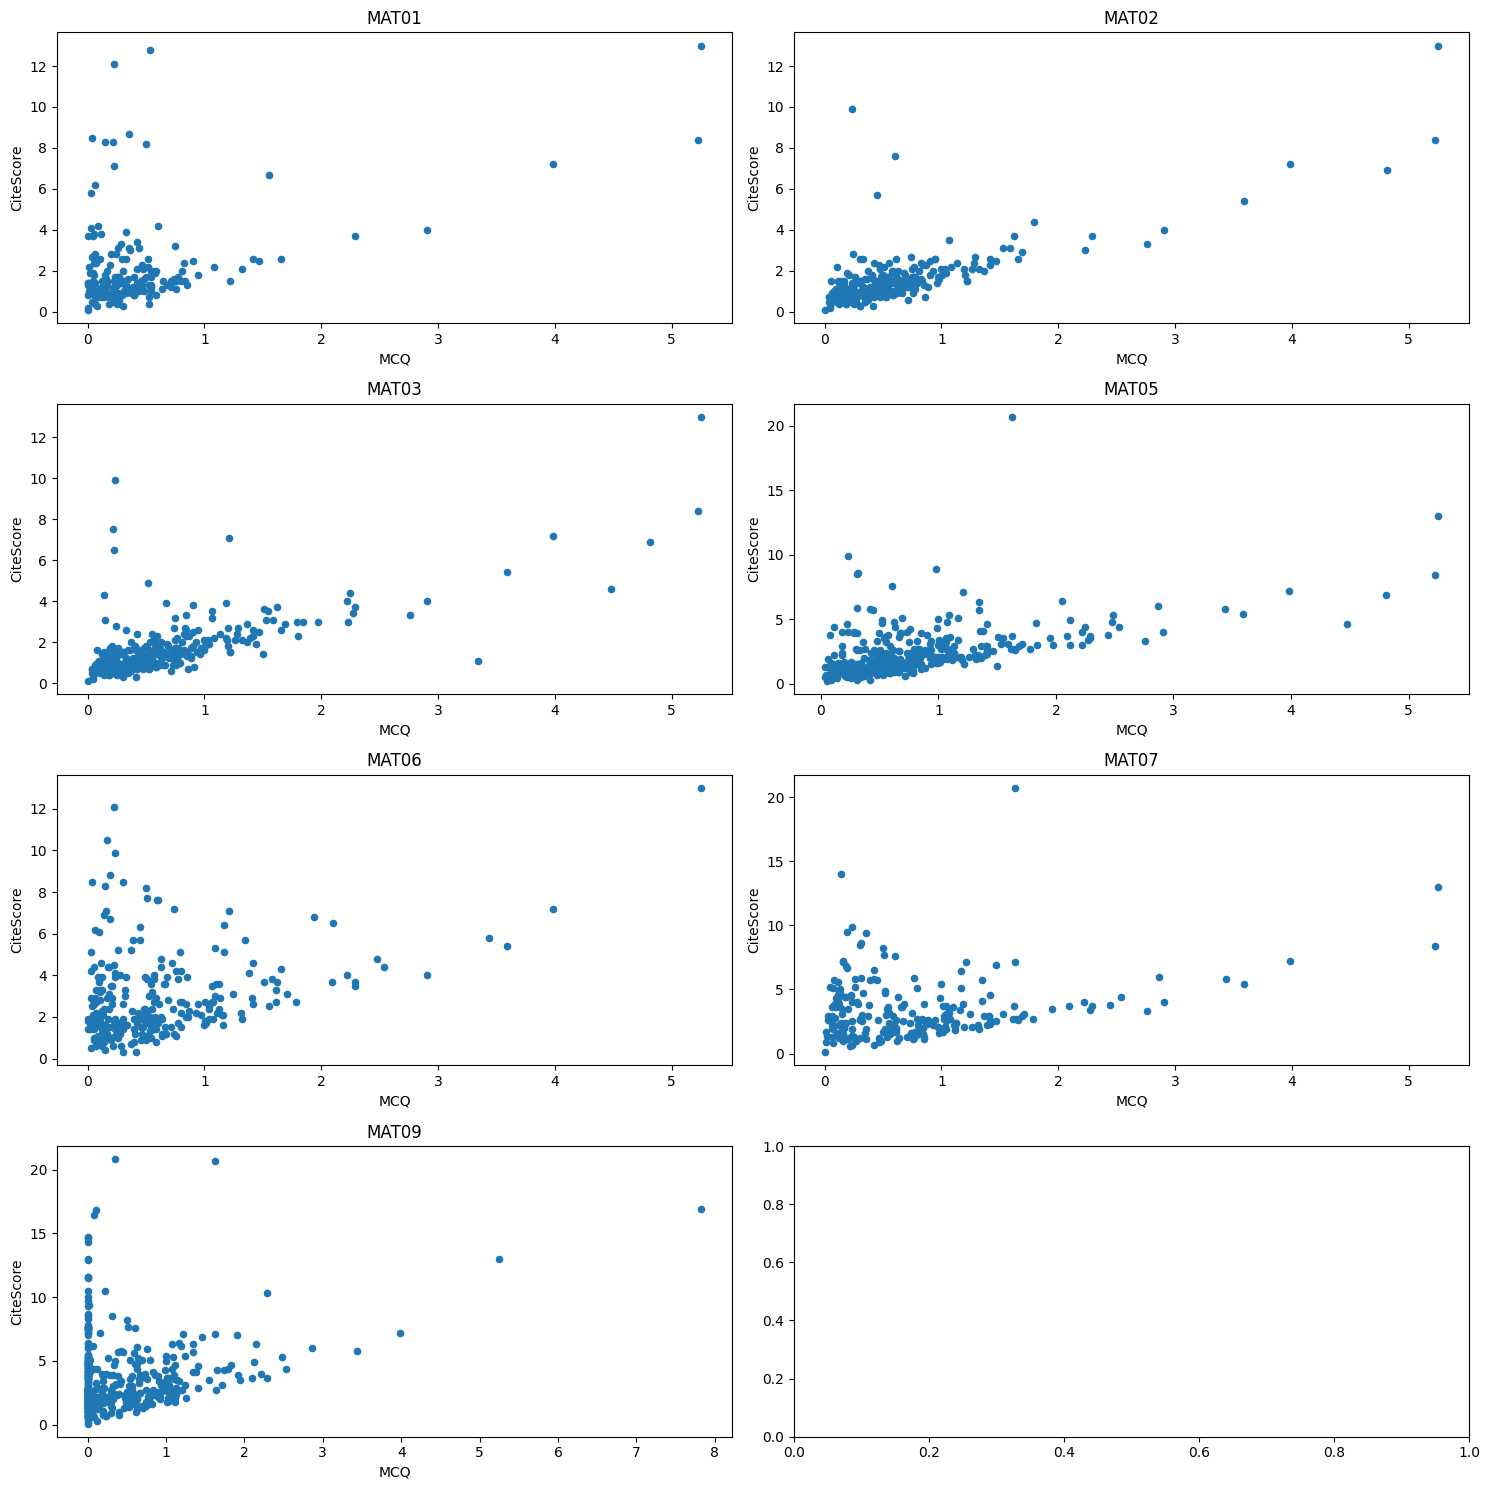

In [14]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="MCQ",y="CiteScore",ax=axes[3,0],title="MAT09")
plt.tight_layout()

In [15]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['CiteScore'],ascending=False).head(10)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,3.984138
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,4.887166
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,9.857442
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,5.069936
1750,IEEE Transactions on Image Processing,10577149,MAT08,2.893,16.4,0.083445,3.218303
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,5.889578
1753,IEEE Transactions on Signal Processing,1053587X,MAT08,2.098,10.5,0.225021,2.228420
1722,Computer Methods in Applied Mechanics and Engi...,00457825; 03742830,MAT08,2.786,10.3,2.292758,2.150712
1749,IEEE Transactions on Antennas and Propagation,0018926X,MAT08,1.697,9.4,0.020510,2.190243
1678,Applied Mathematical Modelling,0307904X,MAT08,0.957,8.5,0.306138,1.742894


# SJR vs CiteScore

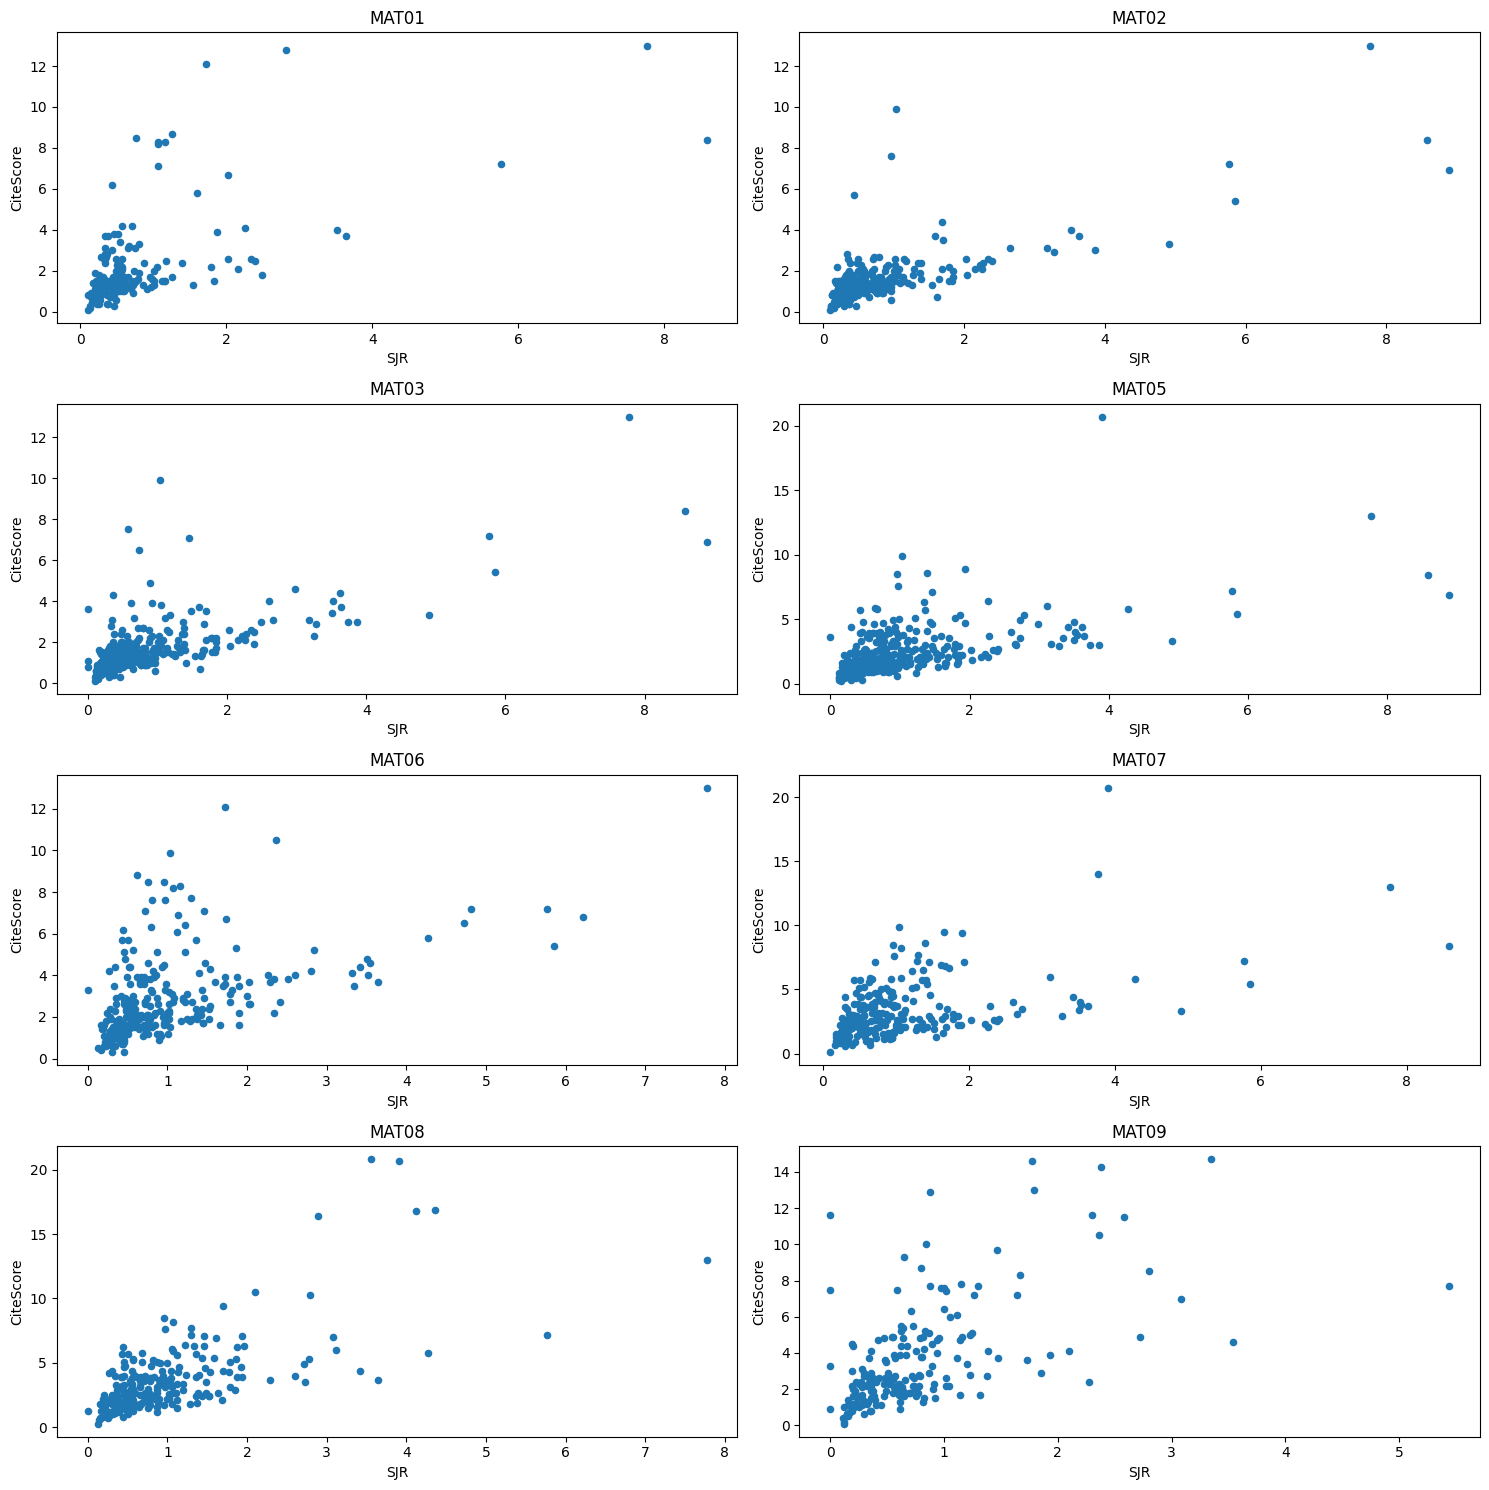

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="SJR",y="CiteScore",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="SJR",y="CiteScore",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="SJR",y="CiteScore",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="SJR",y="CiteScore",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="SJR",y="CiteScore",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="SJR",y="CiteScore",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="SJR",y="CiteScore",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="SJR",y="CiteScore",ax=axes[3,1],title="MAT09")
plt.tight_layout()

In [17]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['CiteScore'],ascending=False).head(10)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,3.984138
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,4.887166
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,9.857442
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,5.069936
1750,IEEE Transactions on Image Processing,10577149,MAT08,2.893,16.4,0.083445,3.218303
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,5.889578
1753,IEEE Transactions on Signal Processing,1053587X,MAT08,2.098,10.5,0.225021,2.228420
1722,Computer Methods in Applied Mechanics and Engi...,00457825; 03742830,MAT08,2.786,10.3,2.292758,2.150712
1749,IEEE Transactions on Antennas and Propagation,0018926X,MAT08,1.697,9.4,0.020510,2.190243
1678,Applied Mathematical Modelling,0307904X,MAT08,0.957,8.5,0.306138,1.742894


## SJR VS SNIP

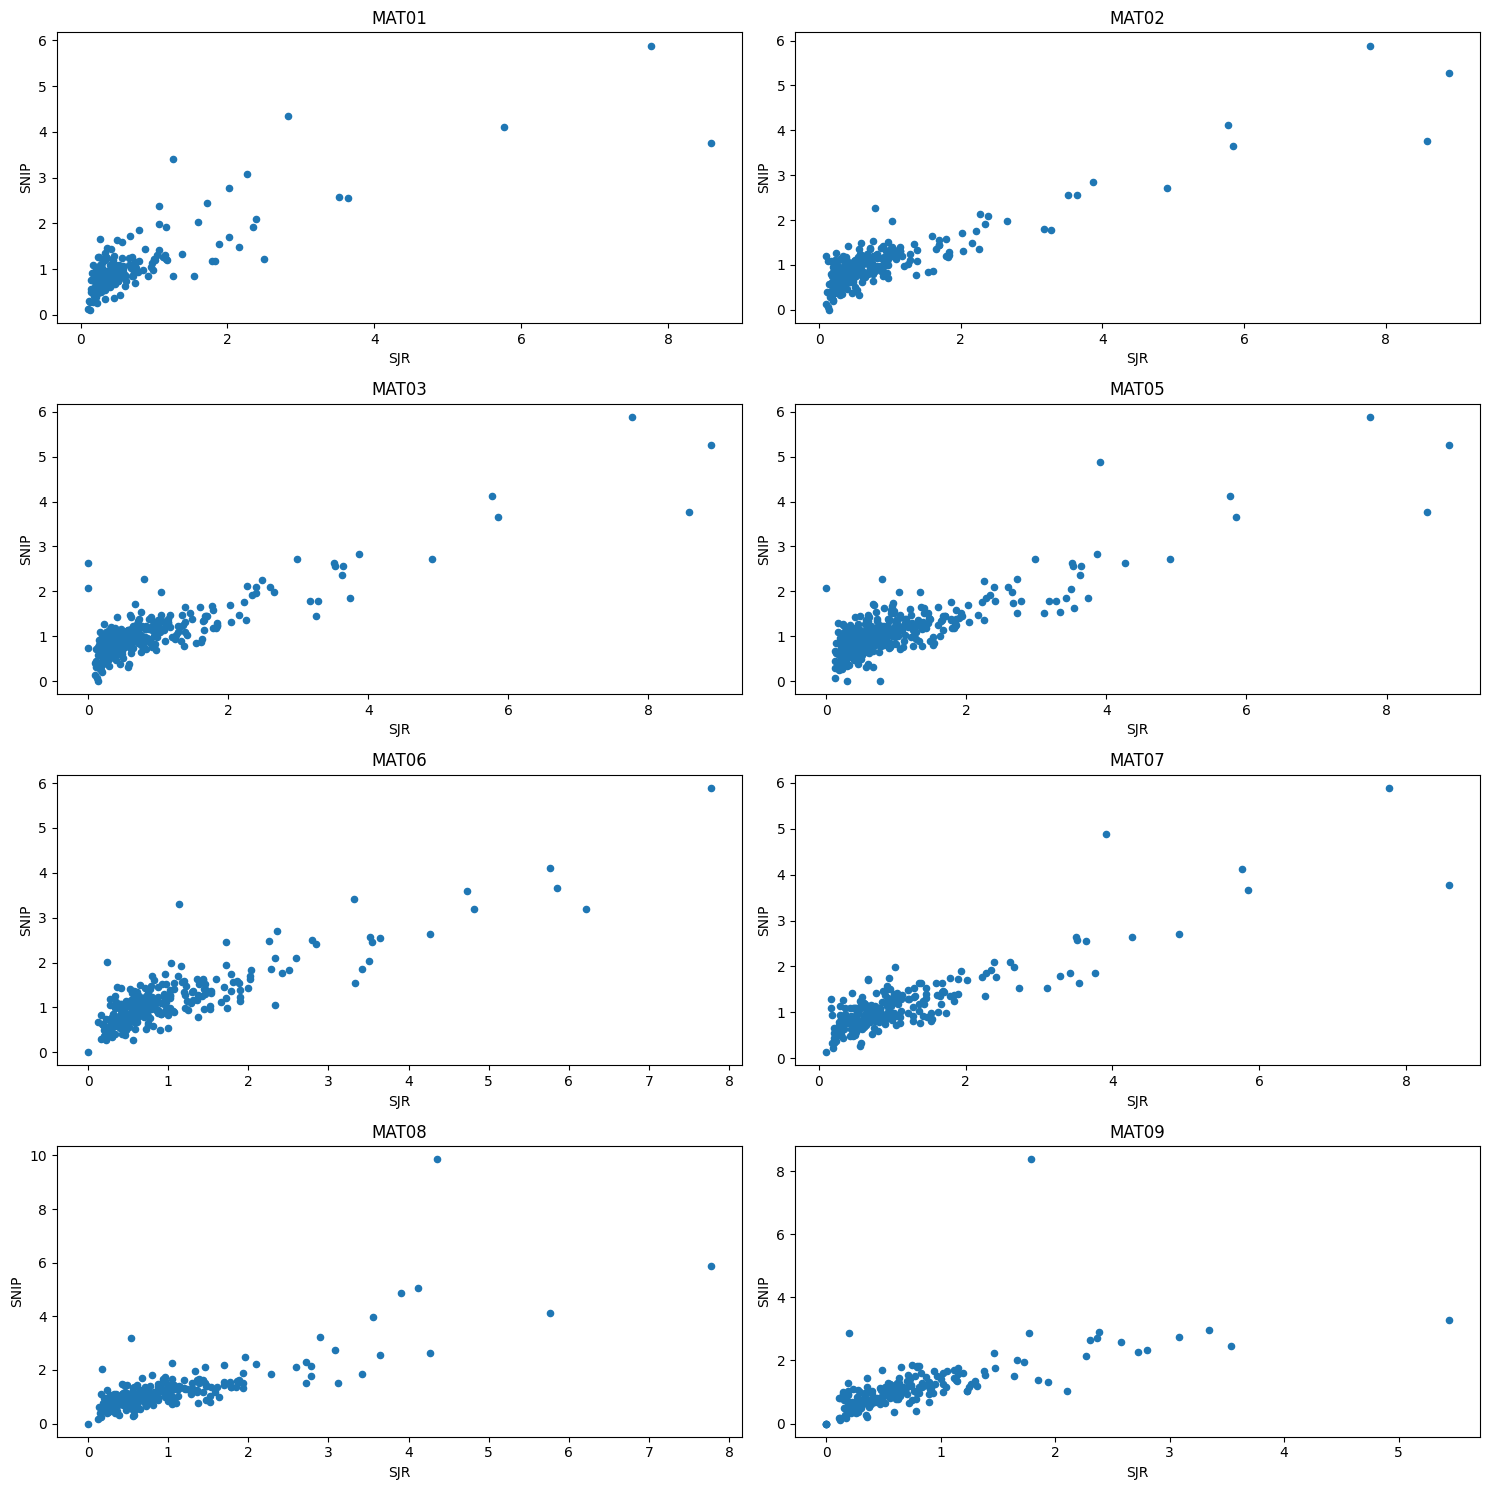

In [18]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
df.loc[df['SETTORE']=='MAT01'].plot.scatter(x="SJR",y="SNIP",ax=axes[0,0],title="MAT01")
df.loc[df['SETTORE']=='MAT02'].plot.scatter(x="SJR",y="SNIP",ax=axes[0,1],title="MAT02")
df.loc[df['SETTORE']=='MAT03'].plot.scatter(x="SJR",y="SNIP",ax=axes[1,0],title="MAT03")
df.loc[df['SETTORE']=='MAT05'].plot.scatter(x="SJR",y="SNIP",ax=axes[1,1],title="MAT05")
df.loc[df['SETTORE']=='MAT06'].plot.scatter(x="SJR",y="SNIP",ax=axes[2,0],title="MAT06")
df.loc[df['SETTORE']=='MAT07'].plot.scatter(x="SJR",y="SNIP",ax=axes[2,1],title="MAT07")
df.loc[df['SETTORE']=='MAT08'].plot.scatter(x="SJR",y="SNIP",ax=axes[3,0],title="MAT08")
df.loc[df['SETTORE']=='MAT09'].plot.scatter(x="SJR",y="SNIP",ax=axes[3,1],title="MAT09")
plt.tight_layout()

## Uno sguardo più approfondito alle misure

Controlliamo le distribuzioni globali delle varie misure.

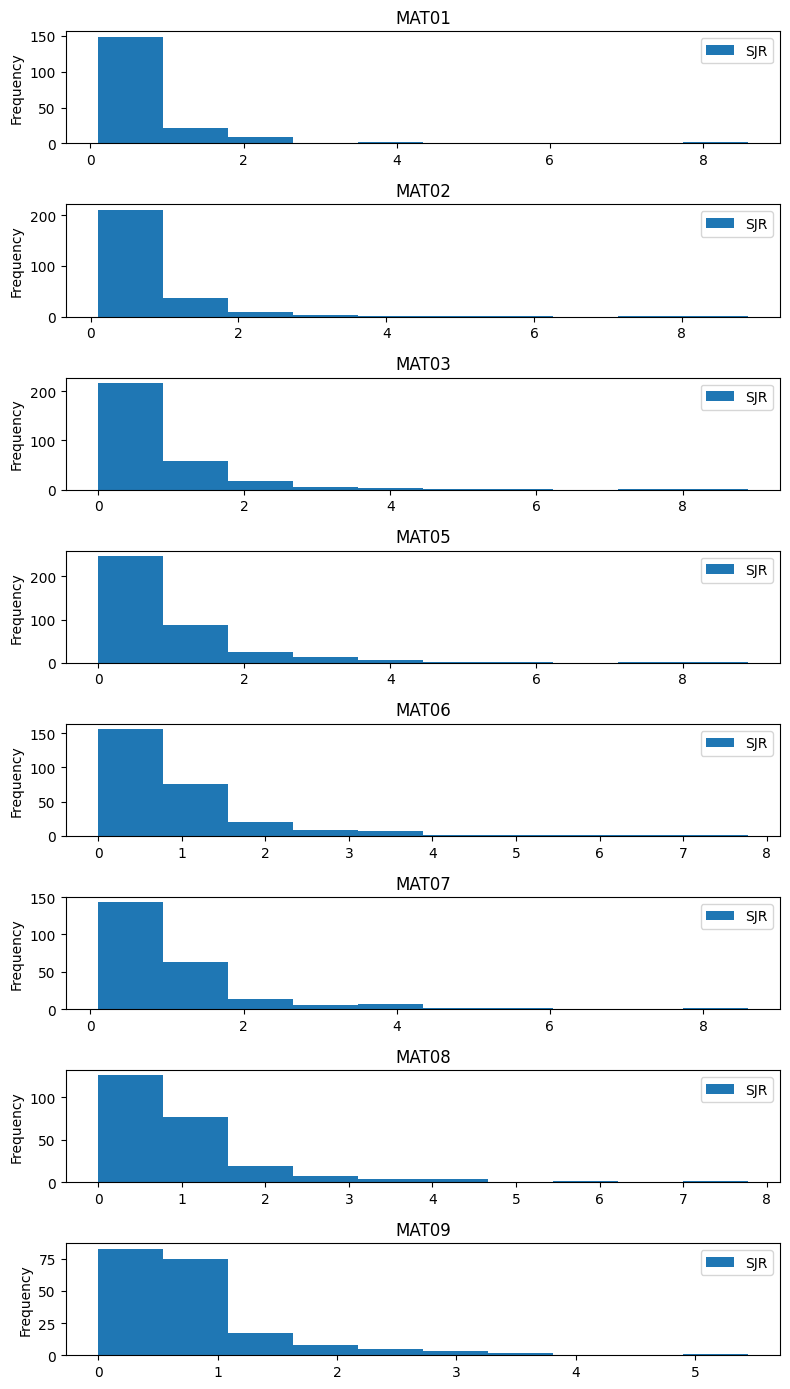

In [19]:
df.plot.hist(column=['SJR'],by="SETTORE",figsize=(8,14))
plt.tight_layout()

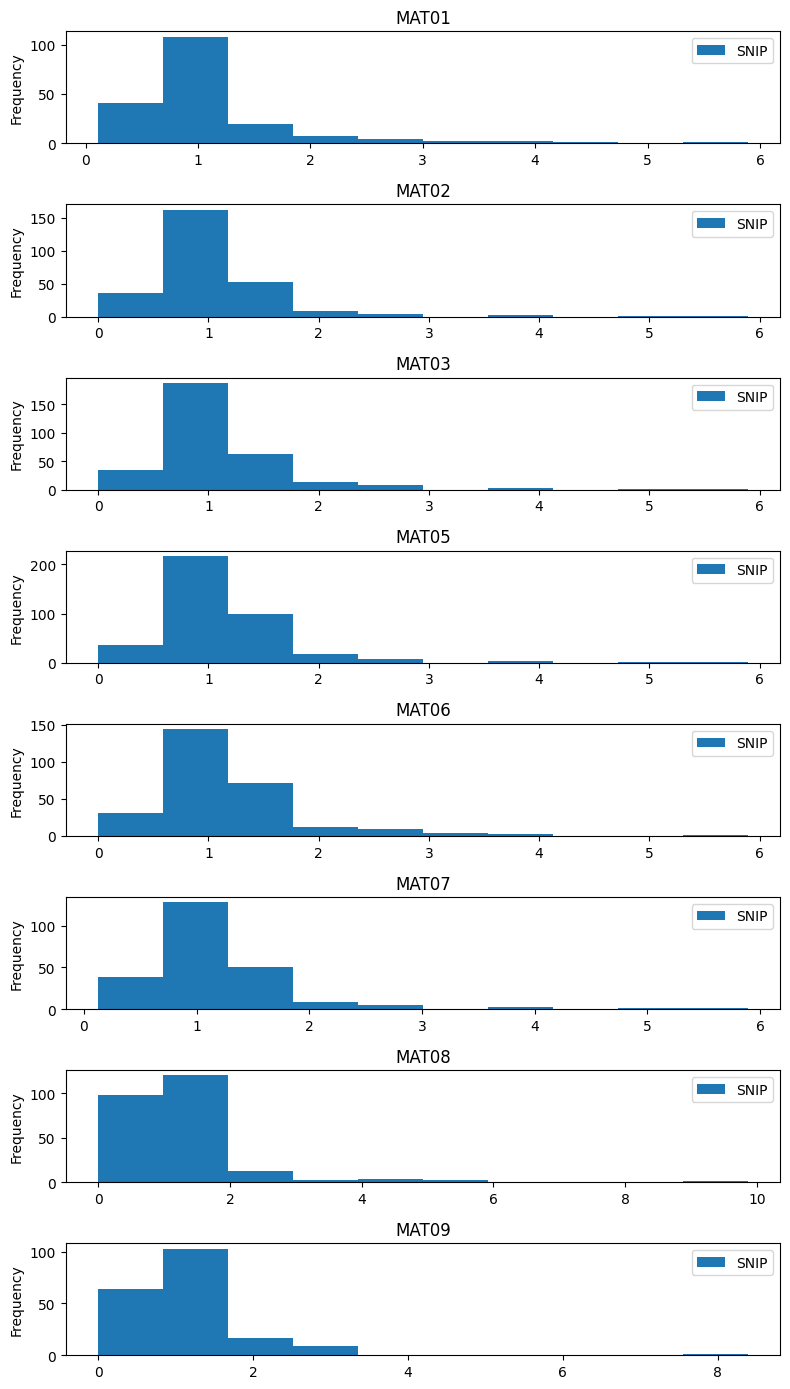

In [20]:
df.plot.hist(column=['SNIP'],by="SETTORE",figsize=(8,14))
plt.tight_layout()

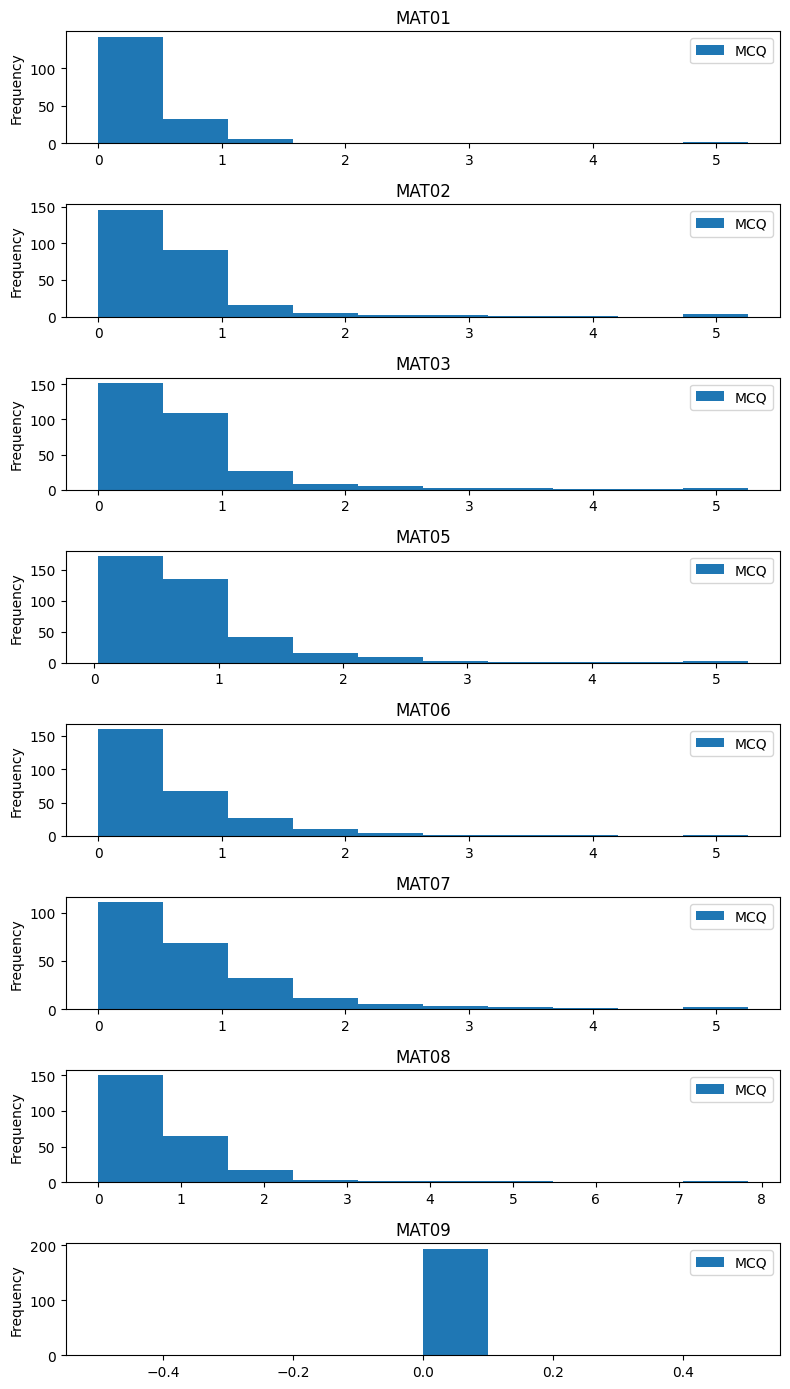

In [21]:
df.plot.hist(column=['MCQ'],by="SETTORE",figsize=(8,14))
plt.tight_layout()

In [22]:
df.loc[df['SETTORE']=="MAT08"].sort_values(by=['SNIP'],ascending=False).head(20)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1667,Acta Numerica,09624929,MAT08,4.358,16.9,7.827586,9.857442
1676,Annals of Mathematics,0003486X,MAT08,7.770,13.0,5.253589,5.889578
1771,International Journal of Computer Vision,09205691,MAT08,4.121,16.8,0.108696,5.069936
1887,SIAM Review,00361445,MAT08,3.910,20.7,1.625899,4.887166
1665,Acta Mathematica,00015962,MAT08,5.766,7.2,3.984615,4.116369
1752,IEEE Transactions on Neural Networks and Learn...,2162237X,MAT08,3.555,20.8,0.344097,3.984138
1750,IEEE Transactions on Image Processing,10577149,MAT08,2.893,16.4,0.083445,3.218303
1775,Internet Mathematics,15427951,MAT08,0.540,2.0,0.329114,3.203176
1839,Mathematical Programming,00255610,MAT08,3.082,7.0,1.904523,2.743969
1703,Communications on Pure and Applied Mathematics,00103640,MAT08,4.271,5.8,3.434615,2.632944


In [23]:
df.loc[df['SETTORE']=="MAT09"].sort_values(by=['SNIP'],ascending=False).head(20)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
2036,Mathematical Programming Computation,18672949,MAT09,1.790,13.0,0.0,8.383635
2031,Management Science,00251909,MAT09,5.439,7.7,0.0,3.283578
2085,Transportation Research Part C: Emerging Techn...,0968090X,MAT09,3.342,14.7,0.0,2.959050
1985,International Journal of Production Economics,09255273,MAT09,2.379,14.3,0.0,2.918126
1923,Computational Social Networks,0,MAT09,0.203,4.4,0.0,2.883974
1986,International Journal of Production Research,00207543,MAT09,1.776,14.6,0.0,2.874624
2035,Mathematical Programming,00255610,MAT09,3.082,7.0,0.0,2.743969
1953,European Journal of Operational Research,03772217,MAT09,2.364,10.5,0.0,2.706389
2086,"Transportation Research, Part E: Logistics and...",13665545,MAT09,2.302,11.6,0.0,2.650618
2053,Omega,03050483,MAT09,2.579,11.5,0.0,2.586244


In [24]:
df.loc[df['SETTORE']=="MAT07"].sort_values(by=['SNIP'],ascending=False).head(20)

,Rivista,ISSN,SETTORE,SJR,CiteScore,MCQ,SNIP
1447,Annals of Mathematics,0003486X,MAT07,7.770,13.0,5.253589,5.889578
1647,SIAM Review,00361445,MAT07,3.910,20.7,1.625899,4.887166
1425,Acta Mathematica,00015962,MAT07,5.766,7.2,3.984615,4.116369
1573,Journal of the American Mathematical Society,08940347,MAT07,8.581,8.4,5.224806,3.767605
1530,Inventiones Mathematicae,00209910,MAT07,5.848,5.4,3.589532,3.656189
1495,Duke Mathematical Journal,00127094,MAT07,4.907,3.3,2.761194,2.714861
1478,Communications on Pure and Applied Mathematics,00103640,MAT07,4.271,5.8,3.434615,2.632944
1513,Geometric and Functional Analysis,1016443X,MAT07,3.508,3.4,2.271493,2.632077
1601,Memoirs of the American Mathematical Society,00659266,MAT07,3.520,4.0,2.909639,2.567543
1574,Journal of the European Mathematical Society,14359855,MAT07,3.639,3.7,2.287129,2.553470
